# 项目：用逻辑回归制作信用评分卡

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR

In [2]:
data = pd.read_csv(r"c:\Users\win10\Desktop\rankingcard.csv",index_col=0)

In [3]:
#探索数据与数据预处理

In [4]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
#观察数据结构
data.shape

(150000, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [7]:
#去除重复值
data.drop_duplicates(inplace=True)

In [8]:
#删除重复值之后千万别忘记恢复索引
data.index = range(data.shape[0])

In [9]:
#填补缺失值

In [10]:
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29221
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3828
dtype: int64

In [11]:
data.isnull().sum()/data.shape[0]  #查看缺失值所占比例  相当于：data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [12]:
#使用均值来填补家属人数
data["NumberOfDependents"].fillna(data["NumberOfDependents"].mean(),inplace=True)

In [13]:
#随机森林填补缺失值对于某一个特征大量缺失，其他特征却很完整的情况下，非常适用。

In [14]:
#写一个能够填补任何列的函数
def fill_missing_rf(X,y,to_fill):
    """
    使用随机森林来填补缺失值
    """
    #构建新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,(df.columns != to_fill)],pd.DataFrame(y)],axis=1)
    
    #找出训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]
    
    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100).fit(Xtrain,Ytrain)
    Ypredict = rfr.predict(Xtest)
    
    return Ypredict

In [15]:
X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]  #data.iloc[:,0]

In [16]:
X.shape

(149391, 10)

In [17]:
y_pred = fill_missing_rf(X,y,'MonthlyIncome')

In [18]:
y_pred.shape

(29221,)

In [19]:
#确认我们的结果合理之后，我们就可以将数据覆盖
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

In [ ]:
"""
描述性统计处理异常值

银行业中，往往使用普通的描述性统计来观察数据的异常与否以及数据的情况。注意，这种方法只能在特征量有限的情况下进行，
如果有几百个特征又无法成功降维或特征选择不管用，还是使用3σ比较好
"""

In [22]:
#描述性统计
data.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5428.150058,13245.811355,0.0,0.0,0.180000,1800.000000,4426.000000,7416.000000,10800.000000,23250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [23]:
#异常值被我们观察到，年龄最小值为0，这不符合银行业务需求，可以查看年龄为0的人有多少
(data["age"] == 0).sum()

1

In [24]:
#发现只有一个人年龄为0，可以判断这肯定是录入失误造成的，可以当成缺失值来处理，直接删除样本
data = data[data["age"] != 0]

In [25]:
data.shape

(149390, 11)

In [27]:
data[data.loc[:,"NumberOfTimes90DaysLate"] > 90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [28]:
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]

In [29]:
data.index = range(data.shape[0])

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

In [ ]:
"""
样本不均衡问题
"""

In [32]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [33]:
y.value_counts()

0    139292
1      9873
Name: SeriousDlqin2yrs, dtype: int64

In [34]:
X.shape

(149165, 10)

In [35]:
n_sample = X.shape[0]
n_1_sample = y.value_counts()[1]
n_0_sample = y.value_counts()[0]
print('样本个数:{}；1占{:.2%};0占{:.2f}'.format(n_sample,n_1_sample/n_sample,n_0_sample/n_sample))

样本个数:149165；1占6.62%;0占0.93


In [1]:
import imblearn
#imblearn 是专门用来处理不平衡数据的库,在处理样本不均衡问题中性能高过sklearn
#imblearn 也是一个个类，也需要进行实例化，fit拟合，用法与sklearn相似
"""
采样方法来平衡样本
"""

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)#实例化
X,y = sm.fit_sample(X,y)
n_sample_ = X.shape[0]


In [38]:
pd.Series(y).value_counts()

1    139292
0    139292
Name: SeriousDlqin2yrs, dtype: int64

In [39]:
n_1_sample = pd.Series(y).value_counts()[1]
n_0_sample = pd.Series(y).value_counts()[0]

print('样本个数:{}；1占{:.2%};0占{:.2%}'.format(n_sample_,n_1_sample/n_sample_,n_0_sample/n_sample_))

样本个数:278584；1占50.00%;0占50.00%


In [40]:
#分训练集和测试集

In [41]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X_train,X_vali,Y_train,Y_vali = train_test_split(X,y,test_size=0.3,random_state=420)
model_data = pd.concat([Y_train,X_train],axis=1)

In [42]:
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns

In [43]:
vali_data = pd.concat([Y_vali,X_vali],axis=1)

In [44]:
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns

In [45]:
model_data.to_csv(r"C:\Users\win10\Desktop\test\model_data.csv")
vali_data.to_csv(r"C:\Users\win10\Desktop\test\vali_data.csv")

In [ ]:
"""
分箱

离散化连续变量

组间差异大，组内差异小
"""

In [47]:
#等频分箱

In [48]:
#按照等频对需要分箱的列进行分箱
#“age”为例子
model_data["qcut"] ,updown = pd.qcut(model_data["age"],retbins=True,q=20)


In [49]:
#dataframe['列名'] #当这个列存在的时候，就是索引
#当这个列名不存在的时候，DataFrame会自动生成叫做这个列名的一个新的列

In [50]:
model_data["qcut"].value_counts()

(36.0, 39.0]      12669
(20.999, 28.0]    11746
(58.0, 61.0]      11412
(48.0, 50.0]      11066
(31.0, 34.0]      10898
(46.0, 48.0]      10897
(50.0, 52.0]      10506
(43.0, 45.0]      10316
(61.0, 64.0]      10154
(39.0, 41.0]       9786
(41.0, 43.0]       9722
(52.0, 54.0]       9665
(28.0, 31.0]       9575
(74.0, 107.0]      9114
(64.0, 68.0]       8903
(54.0, 56.0]       8737
(68.0, 74.0]       8695
(56.0, 58.0]       7934
(34.0, 36.0]       7555
(45.0, 46.0]       5658
Name: qcut, dtype: int64

In [51]:
#统计每个分箱中0,1的数量
#这里使用了数据透视表的功能groupby
coount_y0 = model_data[model_data["SeriousDlqin2yrs"] == 0].groupby(by="qcut").count()["SeriousDlqin2yrs"]
coount_y1 = model_data[model_data["SeriousDlqin2yrs"] == 1].groupby(by="qcut").count()["SeriousDlqin2yrs"]

#num_bins值分别为每个区间的上界，下界，0出现的次数，1出现的次数
num_bins = [*zip(updown,updown[1:],coount_y0,coount_y1)]

In [52]:
num_bins  #注意zip会按照最短的那一个列表来进行结合

[(21.0, 28.0, 4243, 7503),
 (28.0, 31.0, 3571, 6004),
 (31.0, 34.0, 4075, 6823),
 (34.0, 36.0, 2908, 4647),
 (36.0, 39.0, 5182, 7487),
 (39.0, 41.0, 3956, 5830),
 (41.0, 43.0, 4002, 5720),
 (43.0, 45.0, 4389, 5927),
 (45.0, 46.0, 2419, 3239),
 (46.0, 48.0, 4813, 6084),
 (48.0, 50.0, 4900, 6166),
 (50.0, 52.0, 4728, 5778),
 (52.0, 54.0, 4681, 4984),
 (54.0, 56.0, 4677, 4060),
 (56.0, 58.0, 4483, 3451),
 (58.0, 61.0, 6583, 4829),
 (61.0, 64.0, 6968, 3186),
 (64.0, 68.0, 6623, 2280),
 (68.0, 74.0, 6753, 1942),
 (74.0, 107.0, 7737, 1377)]

In [53]:
"""
定义WOE和IV函数
"""

'\n定义WOE和IV函数\n'

In [54]:
columns = ["min","max","count_0","count_1"]  #将num_bins转换成DataFrame表格
df = pd.DataFrame(num_bins,columns=columns)

In [55]:
df.head()

,min,max,count_0,count_1
0,21.0,28.0,4243,7503
1,28.0,31.0,3571,6004
2,31.0,34.0,4075,6823
3,34.0,36.0,2908,4647
4,36.0,39.0,5182,7487


In [56]:
df["total"] = df.count_0 + df.count_1 #一个箱子当中所有的样本数
df["percentage"] = df.total / df.total.sum() #一个箱子里 的样本数，占所有样本数的比例
df["dadrate"] = df.count_1 / df.total
df["good%"] = df.count_0 / df.count_0.sum()
df["bad%"] = df.count_1 / df.count_1.sum()
df["woe"] = np.log(df["good%"] / df["bad%"])

In [57]:
rate = df["good%"] - df["bad%"]
iv_age = np.sum(rate * df["woe"])

In [58]:
iv_age     #对比iv值表格 确定所包含信息的大小

0.3540094695213306

In [59]:
def get_woe(num_bins):
    columns = ["min","max","count_0","count_1"]  #将num_bins转换成DataFrame表格
    df = pd.DataFrame(num_bins,columns=columns)
    df["total"] = df.count_0 + df.count_1 #一个箱子当中所有的样本数
    df["percentage"] = df.total / df.total.sum() #一个箱子里 的样本数，占所有样本数的比例
    df["dadrate"] = df.count_1 / df.total
    df["good%"] = df.count_0 / df.count_0.sum()
    df["bad%"] = df.count_1 / df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df

def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df["woe"])
    return iv

In [ ]:
"""
卡方检验，合并箱体，画出IV曲线
"""

In [61]:
num_bins_ = num_bins.copy()

import matplotlib.pyplot as plt
import scipy


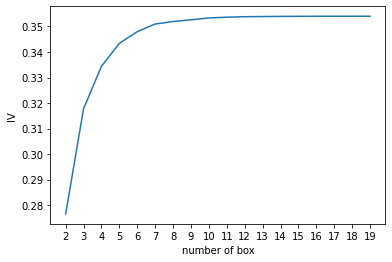

In [62]:
IV = []
axisx = []
while len(num_bins_) > 2:
    pvs = []
    #获取num_bins——两两之间的卡方检验的置信度（或卡方值）
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0返回 chi2 值， 1返回 p 值
        pv = scipy.stats.chi2_contingency([x1,x2])[1]
        #chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
        pvs.append(pv)
        
    #通过p值进行处理。合并p值最大的两组
    i = pvs.index(max(pvs))
    num_bins_[i:i+2] = [(
        num_bins_[i][0],
        num_bins_[i+1][1],
        num_bins_[i][2]+num_bins_[i+1][2],
        num_bins_[i][3]+num_bins_[i+1][3])]
    
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
    
plt.figure()
plt.plot(axisx,IV)
plt.xticks(axisx)
plt.xlabel("number of box")
plt.ylabel("IV")
plt.show()

In [63]:
#用最佳分箱个数分箱，并验证分箱结果

In [ ]:
"""
将合并箱体的部分定义为函数，并实现分箱
"""

In [65]:
def get_bin(num_bins_,n):
    while len(num_bins_) > n:
        pvs = []
        #获取num_bins——两两之间的卡方检验的置信度（或卡方值）
        for i in range(len(num_bins_)-1):
            x1 = num_bins_[i][2:]
            x2 = num_bins_[i+1][2:]
            # 0返回 chi2 值， 1返回 p 值
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            #chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
            pvs.append(pv)

        #通过p值进行处理。合并p值最大的两组
        i = pvs.index(max(pvs))
        num_bins_[i:i+2] = [(
            num_bins_[i][0],
            num_bins_[i+1][1],
            num_bins_[i][2]+num_bins_[i+1][2],
            num_bins_[i][3]+num_bins_[i+1][3])]
    return num_bins_



In [70]:
afterbins = get_bin(num_bins,5)

In [71]:
afterbins

[(21.0, 36.0, 14797, 24977),
 (36.0, 54.0, 39070, 51215),
 (54.0, 61.0, 15743, 12340),
 (61.0, 74.0, 20344, 7408),
 (74.0, 107.0, 7737, 1377)]

In [72]:
bins_df = get_woe(num_bins)

In [73]:
bins_df

,min,max,count_0,count_1,total,percentage,dadrate,good%,bad%,woe
0,21.0,36.0,14797,24977,39774,0.203961,0.627973,0.151467,0.256656,-0.527367
1,36.0,54.0,39070,51215,90285,0.462981,0.567259,0.399934,0.526270,-0.274513
2,54.0,61.0,15743,12340,28083,0.144009,0.439412,0.161151,0.126802,0.239714
3,61.0,74.0,20344,7408,27752,0.142312,0.266936,0.208248,0.076122,1.006390
4,74.0,107.0,7737,1377,9114,0.046737,0.151086,0.079199,0.014150,1.722271


In [ ]:
"""
将选取最佳分箱个数的过程包装成函数
"""

In [110]:
def graphforbestbin(DF,X,Y,n=5,q=20,graph=True):
    """
    自动最优分箱函数，基于卡方检验的分箱
    
    参数：
    DF: 需要输入的数据
    X:需要分箱的特征（列名）
    Y:分箱数据对应的标签Y列名
    n：保留分箱的个数
    q:初始分箱的个数
    graph：是否要画出IV图像
    
    区间为前开后闭(]
    """
    DF = DF[[X,Y]].copy()
    
    DF["qcut"],bins = pd.qcut(DF[X],retbins=True,q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]
    
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue
        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break
    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]  #将num_bins转换成DataFrame表格
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1 #一个箱子当中所有的样本数
        df["percentage"] = df.total / df.total.sum() #一个箱子里 的样本数，占所有样本数的比例
        df["dadrate"] = df.count_1 / df.total
        df["good%"] = df.count_0 / df.count_0.sum()
        df["bad%"] = df.count_1 / df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df
    
    
    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        global bins_df_
        pvs = []
        #获取num_bins——两两之间的卡方检验的置信度（或卡方值）
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            # 0返回 chi2 值， 1返回 p 值
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            #chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
            pvs.append(pv)

        #通过p值进行处理。合并p值最大的两组
        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df_ = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df_))
    
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df_

In [ ]:
"""
对所有特征进行分箱选择
"""

RevolvingUtilizationOfUnsecuredLines


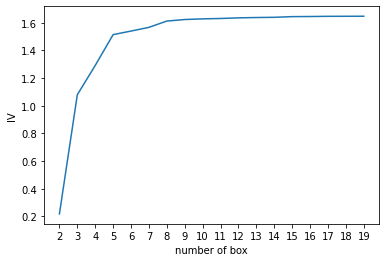

age


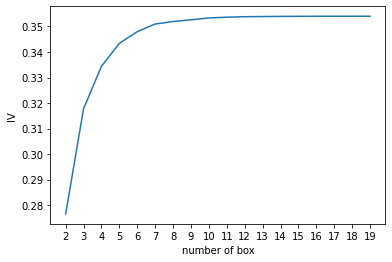

NumberOfTime30-59DaysPastDueNotWorse


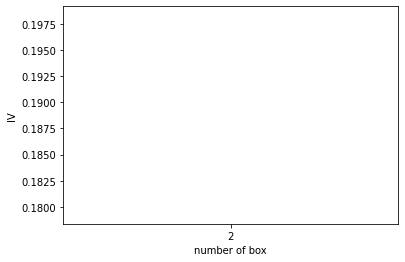

DebtRatio


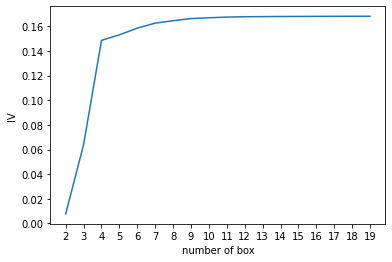

MonthlyIncome


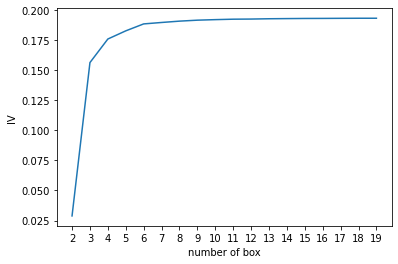

NumberOfOpenCreditLinesAndLoans


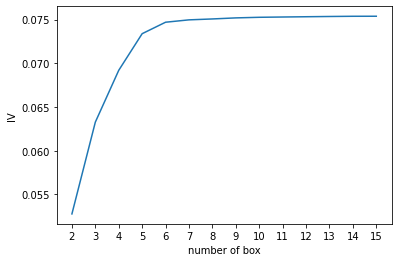

NumberOfTimes90DaysLate


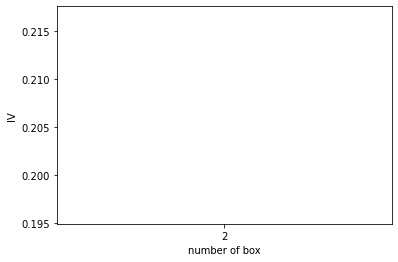

NumberRealEstateLoansOrLines


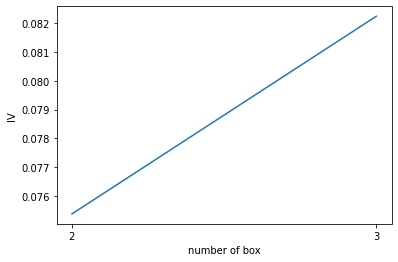

NumberOfTime60-89DaysPastDueNotWorse


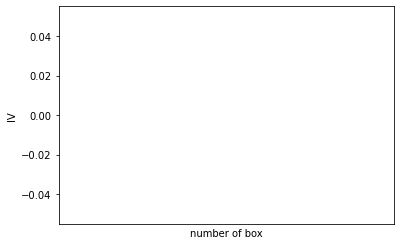

NumberOfDependents


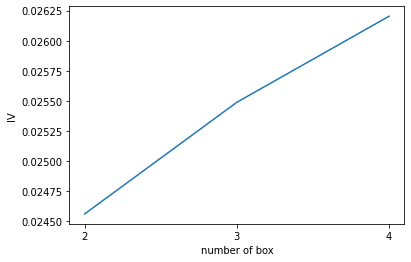

In [111]:
model_data.columns
for i in model_data.columns[1:-1]:
    print(i)
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20,graph=True)

In [ ]:
"""
不是所有特征都可以使用这分箱函数，于是我们可以将可以分箱的特征放出来单独分组，不能分箱的变量自己观察然后手写
"""

In [119]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":5,
                 "age":5,
                 "DebtRatio":4,
                 "MonthlyIncome":4,
                 "NumberOfOpenCreditLinesAndLoans":5}

#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13],
             "NumberOfTimes90DaysLate":[0,1,2,17],
             "NumberRealEstateLoansOrLines":[1,2,4,54],
             "NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8],
             "NumberOfDependents":[0,1,2,3]}

In [120]:
#保证区间覆盖使用np.inf替换最大值，用-np.inf替换最小值
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [121]:
#接下来对所有特征按照选择的箱体个数和手写的分箱范围进行分箱

bins_of_col = {}
#生成自动分箱的分箱区和分箱后的IV值

for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                              ,"SeriousDlqin2yrs"
                              ,n=auto_col_bins[col]
                              #使用字典的性质来取出每个特征所对应的箱的数量
                              ,q=20
                              ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用np.inf替换最大值，-np.inf替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
    #合并手动分箱数据
    bins_of_col.update(hand_bins)

In [122]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09905369654306233,
  0.297831045,
  0.4652966349063259,
  0.9999998999999999,
  inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf],
 'age': [-inf, 36.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01746613090769067,
  0.4016692217302843,
  1.4676877540732731,
  inf],
 'MonthlyIncome': [-inf, 0.11, 0.35, 5599.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf]}

In [ ]:
"""
计算各箱的WOE并映射到数据中
"""

In [123]:
data = model_data.copy()

#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为pd.cut(数据，以列表表示的分箱间隔)
data = data[["age","SeriousDlqin2yrs"]].copy()

In [124]:
data

,age,SeriousDlqin2yrs
0,53,0
1,63,0
2,39,1
3,73,0
4,53,1
...,...,...
195003,32,1
195004,50,1
195005,46,1
195006,64,0


In [126]:
data["cut"] = pd.cut(data["age"],[-np.inf, 36.0, 54.0, 61.0, 74.0, np.inf])
data

,age,SeriousDlqin2yrs,cut
0,53,0,"(36.0, 54.0]"
1,63,0,"(61.0, 74.0]"
2,39,1,"(36.0, 54.0]"
3,73,0,"(61.0, 74.0]"
4,53,1,"(36.0, 54.0]"
...,...,...,...
195003,32,1,"(-inf, 36.0]"
195004,50,1,"(36.0, 54.0]"
195005,46,1,"(36.0, 54.0]"
195006,64,0,"(61.0, 74.0]"


In [127]:
#将数据按分箱结果聚合，并取出其中的标签值
data.groupby("cut")["SeriousDlqin2yrs"].value_counts()

cut           SeriousDlqin2yrs
(-inf, 36.0]  1                   24977
              0                   14797
(36.0, 54.0]  1                   51215
              0                   39070
(54.0, 61.0]  0                   15743
              1                   12340
(61.0, 74.0]  0                   20344
              1                    7408
(74.0, inf]   0                    7737
              1                    1377
Name: SeriousDlqin2yrs, dtype: int64

In [128]:
#unstack函数，将分枝的树状结构变为表状结构

In [129]:
data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

SeriousDlqin2yrs,0,1
cut,,
"(-inf, 36.0]",14797,24977
"(36.0, 54.0]",39070,51215
"(54.0, 61.0]",15743,12340
"(61.0, 74.0]",20344,7408
"(74.0, inf]",7737,1377


In [147]:
bins_df = data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

In [148]:
bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))

In [149]:
bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 36.0]",14797,24977,-0.527367
"(36.0, 54.0]",39070,51215,-0.274513
"(54.0, 61.0]",15743,12340,0.239714
"(61.0, 74.0]",20344,7408,1.006390
"(74.0, inf]",7737,1377,1.722271


In [ ]:
"""
将上述代码包装成函数
"""

In [154]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe

In [155]:
#将所有特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
    

In [156]:
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0991]     2.201667
 (0.0991, 0.298]    0.668665
 (0.298, 0.465]    -0.125724
 (0.465, 1.0]      -0.944614
 (1.0, inf]        -2.044023
 dtype: float64,
 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.354251
 (0.0, 1.0]    -0.876921
 (1.0, 2.0]    -1.379126
 (2.0, inf]    -1.539356
 dtype: float64,
 'NumberOfTimes90DaysLate': cut
 (-inf, 0.0]    0.237964
 (0.0, 1.0]    -1.758536
 (1.0, 2.0]    -2.275888
 (2.0, inf]    -2.419589
 dtype: float64,
 'NumberRealEstateLoansOrLines': cut
 (-inf, 1.0]   -0.145969
 (1.0, 2.0]     0.616699
 (2.0, 4.0]     0.383420
 (4.0, inf]    -0.293206
 dtype: float64,
 'NumberOfTime60-89DaysPastDueNotWorse': cut
 (-inf, 0.0]    0.124885
 (0.0, 1.0]    -1.389862
 (1.0, 2.0]    -1.753144
 (2.0, inf]    -1.837293
 dtype: float64,
 'NumberOfDependents': cut
 (-inf, 0.0]    0.660053
 (0.0, 1.0]    -0.513936
 (1.0, 2.0]    -0.533143
 (2.0, inf]    -0.476130
 dtype: float64,
 'age': cut
 (-inf, 36

In [ ]:
"""
映射数据
"""

In [157]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一样
model_woe = pd.DataFrame(index=model_data.index)

In [163]:
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans
0,-0.274513,2.201667,0.354251,0.237964,-0.145969,0.124885,0.660053,0.036031,-0.301866,-0.052194
1,1.006390,0.668665,0.354251,0.237964,-0.145969,0.124885,0.660053,0.036031,-0.301866,-0.052194
2,-0.274513,-2.044023,-0.876921,-1.758536,-0.145969,-1.753144,-0.476130,-0.389029,-0.301866,-0.052194
3,1.006390,2.201667,0.354251,0.237964,0.616699,0.124885,0.660053,-0.389029,-0.301866,0.125759
4,-0.274513,-0.944614,0.354251,0.237964,0.616699,0.124885,-0.513936,-0.389029,0.232148,0.125759


In [160]:
#将原数据分箱后，按箱的结果把WOE结果用map函数映射到数据中
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])

In [162]:
#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])

In [164]:
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]

In [165]:
model_woe.head()  #得到的是建模用的数据

,age,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,SeriousDlqin2yrs
0,-0.274513,2.201667,0.354251,0.237964,-0.145969,0.124885,0.660053,0.036031,-0.301866,-0.052194,0
1,1.006390,0.668665,0.354251,0.237964,-0.145969,0.124885,0.660053,0.036031,-0.301866,-0.052194,0
2,-0.274513,-2.044023,-0.876921,-1.758536,-0.145969,-1.753144,-0.476130,-0.389029,-0.301866,-0.052194,1
3,1.006390,2.201667,0.354251,0.237964,0.616699,0.124885,0.660053,-0.389029,-0.301866,0.125759,0
4,-0.274513,-0.944614,0.354251,0.237964,0.616699,0.124885,-0.513936,-0.389029,0.232148,0.125759,1


In [ ]:

"""
建模与模型验证
"""

In [166]:
#处理测试集

vali_woe = pd.DataFrame(index=vali_data.index)

for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [167]:
vali_woe.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,SeriousDlqin2yrs
0,2.201667,0.354251,0.237964,-0.145969,0.124885,0.660053,0.239714,1.516812,-0.301866,-0.052194,0
1,-0.944614,0.354251,0.237964,0.616699,0.124885,-0.476130,-0.274513,0.036031,0.232148,0.125759,1
2,2.201667,0.354251,0.237964,-0.145969,0.124885,0.660053,1.006390,0.036031,0.232148,-0.052194,0
3,2.201667,0.354251,0.237964,-0.145969,0.124885,0.660053,-0.274513,0.036031,-0.301866,0.125759,0
4,-0.944614,0.354251,0.237964,-0.145969,0.124885,-0.513936,-0.274513,0.036031,-0.301866,0.125759,1


In [168]:
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [170]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR().fit(X,y)
lr.score(vali_X,vali_y)

0.770448454101656

In [171]:
c_1 = np.linspace(0.01,1,20)
c_2 = np.linspace(0.01,0.2,20)

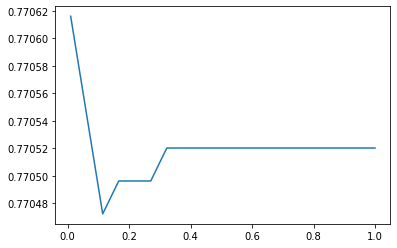

In [176]:
score = []
for i in c_1:
    lr = LR(solver="liblinear",C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_1,score)
plt.show()

In [177]:
lr.n_iter_

array([5], dtype=int32)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

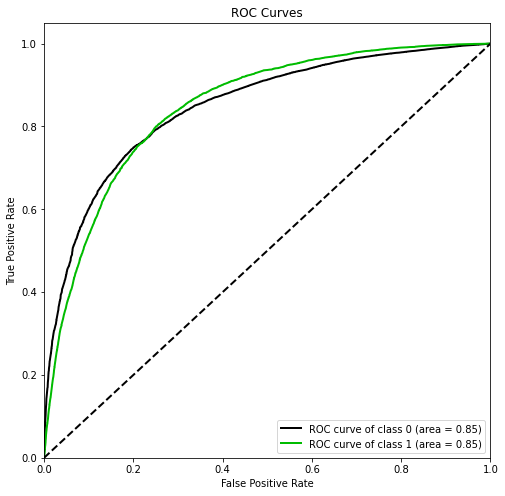

In [180]:
import scikitplot as skplt
vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))

skplt.metrics.plot_roc(vali_y,vali_proba_df,
                      plot_micro=False,figsize=(8,8),
                      plot_macro=False)

In [ ]:
#尽管从准确率来看，我们的模型效果属于一般，但从ROC曲线上的结果来看，模型效果不错

In [ ]:
"""
制作评分卡
""""

In [ ]:
"""
A与B是常数，A叫做“补偿”，B叫做“刻度”，log(adds)代表了一个人违约的可能性
"""

In [181]:
B = 20/np.log(2)
A = 600+B*np.log(1/60)

In [182]:
B,A

(28.85390081777927, 481.8621880878296)

In [183]:

#有了A和B，分数就很容易得到了。其中不受评分卡中各特征影响的基础分，就是将截距作为 带入公式进行计算，而其他各个特征各个分档的分数，也是将系数带入进行计算：
base_score = A - B*lr.intercept_
base_score

array([482.04757406])

In [184]:
score_age = woeall["age"] * (-B*lr.coef_[0][0])
score_age

cut
(-inf, 36.0]    -4.648176
(36.0, 54.0]    -2.419542
(54.0, 61.0]     2.112824
(61.0, 74.0]     8.870255
(74.0, inf]     15.179986
dtype: float64

In [ ]:
#通过循环，将所有特征的评分卡内容全部一次性写往一个本地文件ScoreData.csv：

In [189]:
file =r"C:\Users\win10\Desktop\test\ScoreData.csv"

with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))    
    

#首先写入基准分数
#之后使用循环，每次生成一组score_age类似的分档和分数，不断写入文件之中
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")